# Linear Regression with Python

Linear Regression is the simplest algorithm in machine learning, it can be trained in different ways. In this notebook we will cover the following linear algorithms:

1. Linear Regression
2. Robust Regression
3. Ridge Regression
4. LASSO Regression
5. Elastic Net
6. Polynomial Regression
7. Stochastic Gradient Descent
8. Artificial Neaural Networks

We are going to use the `USA_Housing` dataset. Since house price is a continues variable, this is a regression problem.

The data contains the following columns:

* '`Avg. Area Income`': Avg. Income of residents of the city house is located in.
* '`Avg. Area House Age`': Avg Age of Houses in same city
* '`Avg. Area Number of Rooms`': Avg Number of Rooms for Houses in same city
* '`Avg. Area Number of Bedrooms`': Avg Number of Bedrooms for Houses in same city
* '`Area Population`': Population of city hou  se is located in
* '`Price`': Price that the house sold at
* '`Address`': Address for the house


# Import Libraries

In [1]:
from modelversioncontrol import client
from modelversioncontrol.model import ArtifactRef

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

# Setup ML Aide

In [2]:
project_key = 'us-house-pricing'
api_key = 'YXV0aDB8NWY0MjkxMzM0MjA3ZDEwMDZkZWM1YWYwOsKpNknigJ7igq05wrJ+ZGLigJdw'

options = client.MvcOptions(api_key=api_key)
mvc_client = client.MvcClient(project_key=project_key, options=options)

### Check out the Data

In [3]:
USAhousing = pd.read_csv('data/USA_Housing.csv')
USAhousing.head()

,Avg. Area Income,Avg. Area House Age,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population,Price,Address
0,79545.458574,5.682861,7.009188,4.09,23086.800503,1.059034e+06,"208 Michael Ferry Apt. 674\nLaurabury, NE 3701..."
1,79248.642455,6.002900,6.730821,3.09,40173.072174,1.505891e+06,"188 Johnson Views Suite 079\nLake Kathleen, CA..."
2,61287.067179,5.865890,8.512727,5.13,36882.159400,1.058988e+06,"9127 Elizabeth Stravenue\nDanieltown, WI 06482..."
3,63345.240046,7.188236,5.586729,3.26,34310.242831,1.260617e+06,USS Barnett\nFPO AP 44820
4,59982.197226,5.040555,7.839388,4.23,26354.109472,6.309435e+05,USNS Raymond\nFPO AE 09386


### Log dataset to ML Aide

In [4]:
# create run
run_data_ingest = mvc_client.start_new_run(experiment_key='data-ingest', run_name='data ingest')

# add dataset as artifact
artifact = run_data_ingest.create_artifact(name="USA housing dataset", type="dataset", metadata={})
run_data_ingest.add_artifact_file(artifact, 'data/USA_Housing.csv')
run_data_ingest.set_completed_status()

Run(key=1, name='data ingest', start_time=datetime.datetime(2021, 1, 7, 13, 9, 27, 618162, tzinfo=tzoffset(None, 3600)), end_time=datetime.datetime(2021, 1, 7, 13, 9, 28, 695095), status=<RunStatus.COMPLETED: (3,)>, metrics={}, parameters={})

In [5]:
USAhousing.describe()

,Avg. Area Income,Avg. Area House Age,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population,Price
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5.000000e+03
mean,68583.108984,5.977222,6.987792,3.981330,36163.516039,1.232073e+06
std,10657.991214,0.991456,1.005833,1.234137,9925.650114,3.531176e+05
min,17796.631190,2.644304,3.236194,2.000000,172.610686,1.593866e+04
25%,61480.562388,5.322283,6.299250,3.140000,29403.928702,9.975771e+05
50%,68804.286404,5.970429,7.002902,4.050000,36199.406689,1.232669e+06
75%,75783.338666,6.650808,7.665871,4.490000,42861.290769,1.471210e+06
max,107701.748378,9.519088,10.759588,6.500000,69621.713378,2.469066e+06


# Exploratory Data Analysis (EDA)

Let's create some simple plots to check out the data!

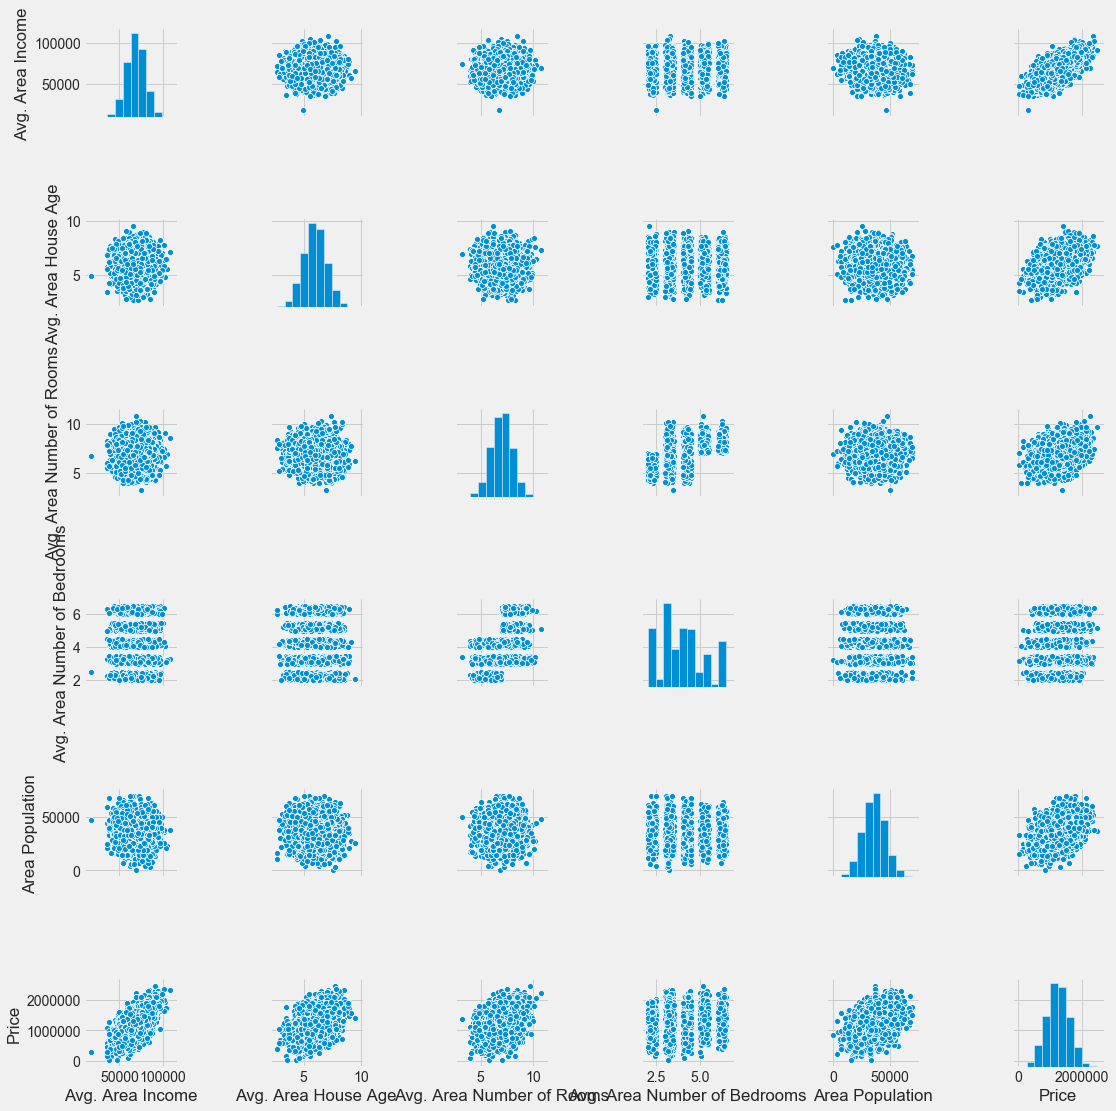

In [6]:
sns.pairplot(USAhousing)

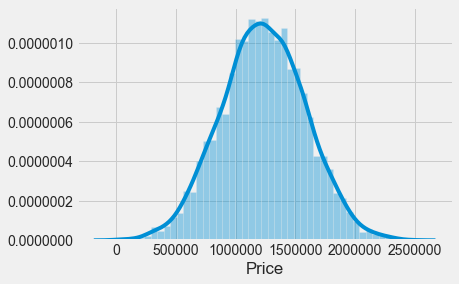

In [7]:
sns.distplot(USAhousing['Price'])

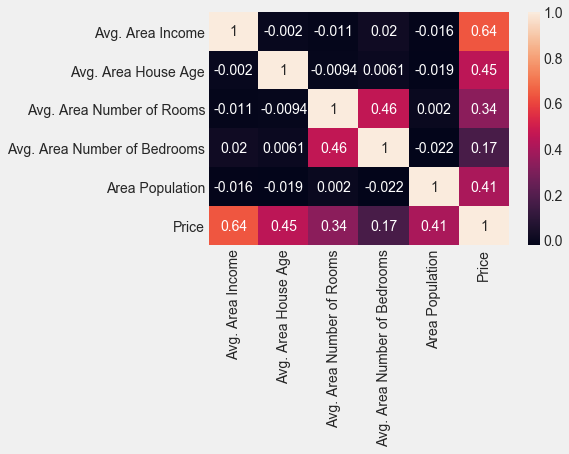

In [8]:
sns.heatmap(USAhousing.corr(), annot=True)

## Training a Linear Regression Model

Let's now begin to train out regression model! We will need to first split up our data into an X array that contains the features to train on, and a y array with the target variable, in this case the Price column. We will toss out the Address column because it only has text info that the linear regression model can't use.

### X and y arrays

In [9]:
X = USAhousing[['Avg. Area Income', 'Avg. Area House Age', 'Avg. Area Number of Rooms',
               'Avg. Area Number of Bedrooms', 'Area Population']]
y = USAhousing['Price']

### Write training preparation to ML Aide

In [10]:
# create run with an reference to the dataset artifact
artifact_ref = ArtifactRef(name="USA housing dataset", version=1)
run_pipeline_setup = mvc_client.start_new_run(experiment_key='pipeline-setup', 
                                              run_name='pipeline setup', 
                                              used_artifacts=[artifact_ref])

## Train Test Split

Now let's split the data into a training set and a testing set. We will train out model on the training set and then use the test set to evaluate the model.

In [11]:
from sklearn.model_selection import train_test_split

test_size=0.3
random_state=42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

run_pipeline_setup.log_parameter('test_size', test_size)
run_pipeline_setup.log_parameter('random_state', random_state)

Run(key=2, name='pipeline setup', start_time=datetime.datetime(2021, 1, 7, 13, 9, 37, 316793, tzinfo=tzoffset(None, 3600)), end_time=None, status=<RunStatus.RUNNING: (1,)>, metrics={}, parameters={'test_size': 0.3, 'random_state': 42})

In [12]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

def cross_val(model):
    pred = cross_val_score(model, X, y, cv=10)
    return pred.mean()

def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

# Preparing Data For Linear Regression
Linear regression is been studied at great length, and there is a lot of literature on how your data must be structured to make best use of the model.

As such, there is a lot of sophistication when talking about these requirements and expectations which can be intimidating. In practice, you can uses these rules more as rules of thumb when using Ordinary Least Squares Regression, the most common implementation of linear regression.

Try different preparations of your data using these heuristics and see what works best for your problem.

- **Linear Assumption.** Linear regression assumes that the relationship between your input and output is linear. It does not support anything else. This may be obvious, but it is good to remember when you have a lot of attributes. You may need to transform data to make the relationship linear (e.g. log transform for an exponential relationship).
- **Remove Noise.** Linear regression assumes that your input and output variables are not noisy. Consider using data cleaning operations that let you better expose and clarify the signal in your data. This is most important for the output variable and you want to remove outliers in the output variable (y) if possible.
- **Remove Collinearity.** Linear regression will over-fit your data when you have highly correlated input variables. Consider calculating pairwise correlations for your input data and removing the most correlated.
- **Gaussian Distributions.** Linear regression will make more reliable predictions if your input and output variables have a Gaussian distribution. You may get some benefit using transforms (e.g. log or BoxCox) on you variables to make their distribution more Gaussian looking.
- **Rescale Inputs:** Linear regression will often make more reliable predictions if you rescale input variables using standardization or normalization.

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('std_scalar', StandardScaler())
])

X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

run_pipeline_setup.log_model(pipeline, model_name="pipeline")
run_pipeline_setup.set_completed_status()

Run(key=2, name='pipeline setup', start_time=datetime.datetime(2021, 1, 7, 13, 9, 37, 316793, tzinfo=tzoffset(None, 3600)), end_time=datetime.datetime(2021, 1, 7, 13, 9, 38, 601449), status=<RunStatus.COMPLETED: (3,)>, metrics={}, parameters={'test_size': 0.3, 'random_state': 42})

# 1. Linear Regression

In [14]:
# create run with an reference to the dataset and the pipeline artifact
dataset_artifact_ref = ArtifactRef(name="USA housing dataset", version=1)
pipeline_artifact_ref = ArtifactRef(name="pipeline", version=1)
run_linear_regression = 
    mvc_client.start_new_run(experiment_key='linear-regression',
                             run_name='linear regression',
                             used_artifacts=[dataset_artifact_ref, pipeline_artifact_ref])

In [15]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression(normalize=True)
lin_reg.fit(X_train,y_train)

run_linear_regression.log_model(lin_reg, 'linear regression')

## Model Evaluation

Let's evaluate the model by checking out it's coefficients and how we can interpret them.

In [16]:
# print the intercept
print(lin_reg.intercept_)

1228219.1492415662


In [17]:
coeff_df = pd.DataFrame(lin_reg.coef_, X.columns, columns=['Coefficient'])
coeff_df

,Coefficient
Avg. Area Income,232679.724643
Avg. Area House Age,163841.046593
Avg. Area Number of Rooms,121110.555478
Avg. Area Number of Bedrooms,2892.815119
Area Population,151252.342377


Interpreting the coefficients:

- Holding all other features fixed, a 1 unit increase in **Avg. Area Income** is associated with an **increase of \$21.52**.
- Holding all other features fixed, a 1 unit increase in **Avg. Area House Age** is associated with an **increase of \$164883.28**.
- Holding all other features fixed, a 1 unit increase in **Avg. Area Number of Rooms** is associated with an **increase of \$122368.67**.
- Holding all other features fixed, a 1 unit increase in **Avg. Area Number of Bedrooms** is associated with an **increase of \$2233.80**.
- Holding all other features fixed, a 1 unit increase in **Area Population** is associated with an **increase of \$15.15**.

Does this make sense? Probably not because I made up this data.

## Predictions from our Model

Let's grab predictions off our test set and see how well it did!

In [18]:
pred = lin_reg.predict(X_test)

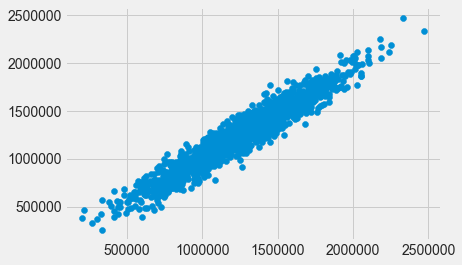

In [19]:
plt.scatter(y_test, pred)

**Residual Histogram**

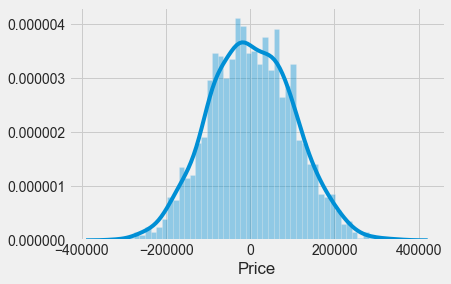

In [20]:
sns.distplot((y_test - pred), bins=50);

## Regression Evaluation Metrics


Here are three common evaluation metrics for regression problems:

**Mean Absolute Error** (MAE) is the mean of the absolute value of the errors:

$$\frac 1n\sum_{i=1}^n|y_i-\hat{y}_i|$$

**Mean Squared Error** (MSE) is the mean of the squared errors:

$$\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2$$

**Root Mean Squared Error** (RMSE) is the square root of the mean of the squared errors:

$$\sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$

Comparing these metrics:

- **MAE** is the easiest to understand, because it's the average error.
- **MSE** is more popular than MAE, because MSE "punishes" larger errors, which tends to be useful in the real world.
- **RMSE** is even more popular than MSE, because RMSE is interpretable in the "y" units.

All of these are **loss functions**, because we want to minimize them.

In [21]:
test_pred = lin_reg.predict(X_test)
train_pred = lin_reg.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

Test set evaluation:
_____________________________________
MAE: 81135.56609336878
MSE: 10068422551.40088
RMSE: 100341.52954485436
R2 Square 0.9146818498754016
Train set evaluation:
_____________________________________
MAE: 81480.49973174892
MSE: 10287043161.197224
RMSE: 101425.06180031257
R2 Square 0.9192986579075526


In [22]:
results_df = pd.DataFrame(data=[["Linear Regression", *evaluate(y_test, test_pred) , cross_val(LinearRegression())]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])

results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,81135.566093,1.006842e+10,100341.529545,0.914682,0.917379


In [23]:
mae, mse, rmse, r2 = evaluate(y_test, test_pred)
cross_validation = cross_val(LinearRegression())

run_linear_regression.log_metric('mae', mae)
run_linear_regression.log_metric('mse', mse)
run_linear_regression.log_metric('rmse', rmse)
run_linear_regression.log_metric('r2', r2)
run_linear_regression.log_metric('cross validation', cross_validation)

run_linear_regression.set_completed_status()

Run(key=3, name='linear regression', start_time=datetime.datetime(2021, 1, 7, 13, 9, 38, 783764, tzinfo=tzoffset(None, 3600)), end_time=datetime.datetime(2021, 1, 7, 13, 9, 40, 349438), status=<RunStatus.COMPLETED: (3,)>, metrics={'mae': 81135.56609336878, 'mse': 10068422551.40088, 'rmse': 100341.52954485436, 'r2': 0.9146818498754016, 'cross validation': 0.9173792621537313}, parameters={})

# 2. Robust Regression

Robust regression is a form of regression analysis designed to overcome some limitations of traditional parametric and non-parametric methods. Robust regression methods are designed to be not overly affected by violations of assumptions by the underlying data-generating process.

One instance in which robust estimation should be considered is when there is a strong suspicion of `heteroscedasticity`.

A common situation in which robust estimation is used occurs when the data contain outliers. In the presence of outliers that do not come from the same data-generating process as the rest of the data, least squares estimation is inefficient and can be biased. Because the least squares predictions are dragged towards the outliers, and because the variance of the estimates is artificially inflated, the result is that outliers can be masked. (In many situations, including some areas of geostatistics and medical statistics, it is precisely the outliers that are of interest.)

## Random Sample Consensus - RANSAC

Random sample consensus (`RANSAC`) is an iterative method to estimate parameters of a mathematical model from a set of observed data that contains outliers, when outliers are to be accorded no influence on the values of the estimates. Therefore, it also can be interpreted as an outlier detection method.

A basic assumption is that the data consists of "inliers", i.e., data whose distribution can be explained by some set of model parameters, though may be subject to noise, and "outliers" which are data that do not fit the model. The outliers can come, for example, from extreme values of the noise or from erroneous measurements or incorrect hypotheses about the interpretation of data. RANSAC also assumes that, given a (usually small) set of inliers, there exists a procedure which can estimate the parameters of a model that optimally explains or fits this data.

In [24]:
# create run with an reference to the dataset and the pipeline artifact
dataset_artifact_ref = ArtifactRef(name="USA housing dataset", version=1)
pipeline_artifact_ref = ArtifactRef(name="pipeline", version=1)
run_ransac = mvc_client.start_new_run(experiment_key='random-sample-consensus',
                                      run_name='random sample consensus',
                                      used_artifacts=[dataset_artifact_ref, pipeline_artifact_ref])

In [25]:
from sklearn.linear_model import RANSACRegressor

model = RANSACRegressor(base_estimator=LinearRegression(), max_trials=100)
model.fit(X_train, y_train)

test_pred = model.predict(X_test)
train_pred = model.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

run_ransac.log_model(model, 'RANSAC')

Test set evaluation:
_____________________________________
MAE: 83421.29116107429
MSE: 10673700292.321936
RMSE: 103313.60168110458
R2 Square 0.9095528262469887
Train set evaluation:
_____________________________________
MAE: 84607.55777054117
MSE: 11126348376.735714
RMSE: 105481.50727371938
R2 Square 0.9127143502247933


In [26]:
results_df_2 = pd.DataFrame(data=[["Robust Regression", *evaluate(y_test, test_pred) , cross_val(RANSACRegressor())]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,81135.566093,1.006842e+10,100341.529545,0.914682,0.917379
1,Robust Regression,83421.291161,1.067370e+10,103313.601681,0.909553,0.912898


In [27]:
mae, mse, rmse, r2 = evaluate(y_test, test_pred)
cross_validation = cross_val(RANSACRegressor())

run_ransac.log_metric('mae', mae)
run_ransac.log_metric('mse', mse)
run_ransac.log_metric('rmse', rmse)
run_ransac.log_metric('r2', r2)
run_ransac.log_metric('cross validation', cross_validation)

run_ransac.set_completed_status()

Run(key=4, name='random sample consensus', start_time=datetime.datetime(2021, 1, 7, 13, 9, 40, 552754, tzinfo=tzoffset(None, 3600)), end_time=datetime.datetime(2021, 1, 7, 13, 9, 41, 983607), status=<RunStatus.COMPLETED: (3,)>, metrics={'mae': 83421.29116107429, 'mse': 10673700292.321936, 'rmse': 103313.60168110458, 'r2': 0.9095528262469887, 'cross validation': 0.914247650776821}, parameters={})

# 3. Ridge Regression

Source: [scikit-learn](http://scikit-learn.org/stable/modules/linear_model.html#ridge-regression)

Ridge regression addresses some of the problems of **Ordinary Least Squares** by imposing a penalty on the size of coefficients. The ridge coefficients minimize a penalized residual sum of squares,

$$\min_{w}\big|\big|Xw-y\big|\big|^2_2+\alpha\big|\big|w\big|\big|^2_2$$

$\alpha>=0$ is a complexity parameter that controls the amount of shrinkage: the larger the value of $\alpha$, the greater the amount of shrinkage and thus the coefficients become more robust to collinearity.

Ridge regression is an L2 penalized model. Add the squared sum of the weights to the least-squares cost function.
***

In [28]:
def train_ridge(alpha, solver, tol, random_state):
    # create run with an reference to the dataset and the pipeline artifact
    dataset_artifact_ref = ArtifactRef(name="USA housing dataset", version=1)
    pipeline_artifact_ref = ArtifactRef(name="pipeline", version=1)
    run_ridge = mvc_client.start_new_run(experiment_key='ridge-regression',
                                         run_name='ridge regression',
                                         used_artifacts=[dataset_artifact_ref, pipeline_artifact_ref])

    # log params
    run_ridge.log_parameter('alpha', alpha)
    run_ridge.log_parameter('solver', solver)
    run_ridge.log_parameter('tol', tol)
    run_ridge.log_parameter('random state', random_state)
    
    model = Ridge(alpha=alpha, solver=solver, tol=tol, random_state=random_state)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    
    # log model
    run_ridge.log_model(model, 'ridge')

    test_pred = model.predict(X_test)
    train_pred = model.predict(X_train)

    print('Test set evaluation:\n_____________________________________')
    print_evaluate(y_test, test_pred)
    print('====================================')
    print('Train set evaluation:\n_____________________________________')
    print_evaluate(y_train, train_pred)
    
    mae, mse, rmse, r2 = evaluate(y_test, test_pred)
    cross_validation = cross_val(Ridge())

    # log metrics
    run_ridge.log_metric('mae', mae)
    run_ridge.log_metric('mse', mse)
    run_ridge.log_metric('rmse', rmse)
    run_ridge.log_metric('r2', r2)
    run_ridge.log_metric('cross validation', cross_validation)

    run_ridge.set_completed_status()

In [29]:
from sklearn.linear_model import Ridge

train_ridge(100, 'cholesky', 0.0001, 42)
train_ridge(90, 'cholesky', 0.0001, 42)
train_ridge(80, 'cholesky', 0.0001, 42)
train_ridge(80, 'cholesky', 0.0002, 47)

Test set evaluation:
_____________________________________
MAE: 81428.64835535336
MSE: 10153269900.89261
RMSE: 100763.43533689495
R2 Square 0.9139628674464607
Train set evaluation:
_____________________________________
MAE: 81972.39058585509
MSE: 10382929615.143457
RMSE: 101896.66145239233
R2 Square 0.9185464334441484
Test set evaluation:
_____________________________________
MAE: 81375.57997734274
MSE: 10137119736.361332
RMSE: 100683.26443039742
R2 Square 0.9140997212738584
Train set evaluation:
_____________________________________
MAE: 81889.36551715853
MSE: 10365190666.828272
RMSE: 101809.58042752299
R2 Square 0.9186855946116396
Test set evaluation:
_____________________________________
MAE: 81328.22578207571
MSE: 10122586382.29686
RMSE: 100611.06490986397
R2 Square 0.9142228745163407
Train set evaluation:
_____________________________________
MAE: 81816.80559516067
MSE: 10349171961.488539
RMSE: 101730.88007821685
R2 Square 0.9188112605585247
Test set evaluation:
__________________

In [30]:
results_df_2 = pd.DataFrame(data=[["Ridge Regression", *evaluate(y_test, test_pred) , cross_val(Ridge())]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,81135.566093,1.006842e+10,100341.529545,0.914682,0.917379
1,Robust Regression,83421.291161,1.067370e+10,103313.601681,0.909553,0.912898
2,Ridge Regression,83421.291161,1.067370e+10,103313.601681,0.909553,0.917379


# 4. LASSO Regression

A linear model that estimates sparse coefficients.

Mathematically, it consists of a linear model trained with $\ell_1$ prior as regularizer. The objective function to minimize is:

$$\min_{w}\frac{1}{2n_{samples}} \big|\big|Xw - y\big|\big|_2^2 + \alpha \big|\big|w\big|\big|_1$$

The lasso estimate thus solves the minimization of the least-squares penalty with $\alpha \big|\big|w\big|\big|_1$ added, where $\alpha$ is a constant and $\big|\big|w\big|\big|_1$ is the $\ell_1-norm$ of the parameter vector.
***

In [31]:
# create run with an reference to the dataset and the pipeline artifact
dataset_artifact_ref = ArtifactRef(name="USA housing dataset", version=1)
pipeline_artifact_ref = ArtifactRef(name="pipeline", version=1)
run_lasso = mvc_client.start_new_run(experiment_key='lasso-regression',
                                     run_name='lasso regression',
                                     used_artifacts=[dataset_artifact_ref, pipeline_artifact_ref])

In [32]:
from sklearn.linear_model import Lasso

alpha = 0.1
precompute = True
positive = True
selection = 'random'
random_state = 42

run_lasso.log_parameter('alpha', alpha)
run_lasso.log_parameter('precompute', precompute)
run_lasso.log_parameter('positive', positive)
run_lasso.log_parameter('selection', selection)
run_lasso.log_parameter('random state', random_state)
    
model = Lasso(alpha=alpha, 
              precompute=precompute, 
#               warm_start=True, 
              positive=positive, 
              selection=selection,
              random_state=random_state)
model.fit(X_train, y_train)

run_lasso.log_model(model, 'lasso')

test_pred = model.predict(X_test)
train_pred = model.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

Test set evaluation:
_____________________________________
MAE: 81135.6985172622
MSE: 10068453390.364523
RMSE: 100341.68321472648
R2 Square 0.914681588551116
Train set evaluation:
_____________________________________
MAE: 81480.63002185506
MSE: 10287043196.634295
RMSE: 101425.0619750084
R2 Square 0.9192986576295505


In [33]:
results_df_2 = pd.DataFrame(data=[["Lasso Regression", *evaluate(y_test, test_pred) , cross_val(Lasso())]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,81135.566093,1.006842e+10,100341.529545,0.914682,0.917379
1,Robust Regression,83421.291161,1.067370e+10,103313.601681,0.909553,0.912898
2,Ridge Regression,83421.291161,1.067370e+10,103313.601681,0.909553,0.917379
3,Lasso Regression,81135.698517,1.006845e+10,100341.683215,0.914682,0.917379


In [34]:
mae, mse, rmse, r2 = evaluate(y_test, test_pred)
cross_validation = cross_val(Lasso())

run_lasso.log_metric('mae', mae)
run_lasso.log_metric('mse', mse)
run_lasso.log_metric('rmse', rmse)
run_lasso.log_metric('r2', r2)
run_lasso.log_metric('cross validation', cross_validation)

run_lasso.set_completed_status()

Run(key=9, name='lasso regression', start_time=datetime.datetime(2021, 1, 7, 13, 9, 48, 89664, tzinfo=tzoffset(None, 3600)), end_time=datetime.datetime(2021, 1, 7, 13, 9, 49, 506360), status=<RunStatus.COMPLETED: (3,)>, metrics={'mae': 81135.6985172622, 'mse': 10068453390.364523, 'rmse': 100341.68321472648, 'r2': 0.914681588551116, 'cross validation': 0.9173792625728996}, parameters={'alpha': 0.1, 'precompute': True, 'positive': True, 'selection': 'random', 'random state': 42})

# 5. Elastic Net

A linear regression model trained with L1 and L2 prior as regularizer. 

This combination allows for learning a sparse model where few of the weights are non-zero like Lasso, while still maintaining the regularization properties of Ridge. 

Elastic-net is useful when there are multiple features which are correlated with one another. Lasso is likely to pick one of these at random, while elastic-net is likely to pick both.

A practical advantage of trading-off between Lasso and Ridge is it allows Elastic-Net to inherit some of Ridge’s stability under rotation.

The objective function to minimize is in this case

$$\min_{w}{\frac{1}{2n_{samples}} \big|\big|X w - y\big|\big|_2 ^ 2 + \alpha \rho \big|\big|w\big|\big|_1 +
\frac{\alpha(1-\rho)}{2} \big|\big|w\big|\big|_2 ^ 2}$$
***

In [35]:
# create run with an reference to the dataset and the pipeline artifact
dataset_artifact_ref = ArtifactRef(name="USA housing dataset", version=1)
pipeline_artifact_ref = ArtifactRef(name="pipeline", version=1)
run_elastic_net = mvc_client.start_new_run(experiment_key='elastic-net',
                                           run_name='elastic net',
                                           used_artifacts=[dataset_artifact_ref, pipeline_artifact_ref])

In [36]:
from sklearn.linear_model import ElasticNet

alpha = 0.1
l1_ratio = 0.9
selection = 'random'
random_state = 42

run_elastic_net.log_parameter('alpha', alpha)
run_elastic_net.log_parameter('l1_ratio', l1_ratio)
run_elastic_net.log_parameter('selection', selection)
run_elastic_net.log_parameter('random state', random_state)

model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, selection=selection, random_state=random_state)
model.fit(X_train, y_train)

run_elastic_net.log_model(model, 'elastic net')

test_pred = model.predict(X_test)
train_pred = model.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

Test set evaluation:
_____________________________________
MAE: 81184.43147330945
MSE: 10078050168.470106
RMSE: 100389.49232100991
R2 Square 0.9146002670381437
Train set evaluation:
_____________________________________
MAE: 81577.88831531754
MSE: 10299274948.10146
RMSE: 101485.34351373828
R2 Square 0.9192027001474953


In [37]:
results_df_2 = pd.DataFrame(data=[["Elastic Net Regression", *evaluate(y_test, test_pred) , cross_val(ElasticNet())]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,81135.566093,1.006842e+10,100341.529545,0.914682,0.917379
1,Robust Regression,83421.291161,1.067370e+10,103313.601681,0.909553,0.912898
2,Ridge Regression,83421.291161,1.067370e+10,103313.601681,0.909553,0.917379
3,Lasso Regression,81135.698517,1.006845e+10,100341.683215,0.914682,0.917379
4,Elastic Net Regression,81184.431473,1.007805e+10,100389.492321,0.914600,0.879545


In [38]:
mae, mse, rmse, r2 = evaluate(y_test, test_pred)
cross_validation = cross_val(ElasticNet())

run_elastic_net.log_metric('mae', mae)
run_elastic_net.log_metric('mse', mse)
run_elastic_net.log_metric('rmse', rmse)
run_elastic_net.log_metric('r2', r2)
run_elastic_net.log_metric('cross validation', cross_validation)

run_elastic_net.set_completed_status()

Run(key=10, name='elastic net', start_time=datetime.datetime(2021, 1, 7, 13, 9, 49, 683311, tzinfo=tzoffset(None, 3600)), end_time=datetime.datetime(2021, 1, 7, 13, 9, 51, 162969), status=<RunStatus.COMPLETED: (3,)>, metrics={'mae': 81184.43147330945, 'mse': 10078050168.470106, 'rmse': 100389.49232100991, 'r2': 0.9146002670381437, 'cross validation': 0.8795451849577007}, parameters={'alpha': 0.1, 'l1_ratio': 0.9, 'selection': 'random', 'random state': 42})

# 6. Polynomial Regression
Source: [scikit-learn](http://scikit-learn.org/stable/modules/linear_model.html#polynomial-regression-extending-linear-models-with-basis-functions)
***
One common pattern within machine learning is to use linear models trained on nonlinear functions of the data. This approach maintains the generally fast performance of linear methods, while allowing them to fit a much wider range of data.

For example, a simple linear regression can be extended by constructing polynomial features from the coefficients. In the standard linear regression case, you might have a model that looks like this for two-dimensional data:

$$\hat{y}(w, x) = w_0 + w_1 x_1 + w_2 x_2$$

If we want to fit a paraboloid to the data instead of a plane, we can combine the features in second-order polynomials, so that the model looks like this:

$$\hat{y}(w, x) = w_0 + w_1 x_1 + w_2 x_2 + w_3 x_1 x_2 + w_4 x_1^2 + w_5 x_2^2$$

The (sometimes surprising) observation is that this is still a linear model: to see this, imagine creating a new variable

$$z = [x_1, x_2, x_1 x_2, x_1^2, x_2^2]$$

With this re-labeling of the data, our problem can be written

$$\hat{y}(w, x) = w_0 + w_1 z_1 + w_2 z_2 + w_3 z_3 + w_4 z_4 + w_5 z_5$$

We see that the resulting polynomial regression is in the same class of linear models we’d considered above (i.e. the model is linear in w) and can be solved by the same techniques. By considering linear fits within a higher-dimensional space built with these basis functions, the model has the flexibility to fit a much broader range of data.
***

In [39]:
# create run with an reference to the dataset and the pipeline artifact
dataset_artifact_ref = ArtifactRef(name="USA housing dataset", version=1)
pipeline_artifact_ref = ArtifactRef(name="pipeline", version=1)
run_polynomial_regression = mvc_client.start_new_run(experiment_key='polynomial-regression',
                                                     run_name='polynomial regression',
                                                     used_artifacts=[dataset_artifact_ref, pipeline_artifact_ref])

In [40]:
from sklearn.preprocessing import PolynomialFeatures

degree = 2

run_polynomial_regression.log_parameter('degree', degree)

poly_reg = PolynomialFeatures(degree=degree)

X_train_2_d = poly_reg.fit_transform(X_train)
X_test_2_d = poly_reg.transform(X_test)

lin_reg = LinearRegression(normalize=True)
lin_reg.fit(X_train_2_d,y_train)

run_polynomial_regression.log_model(lin_reg, 'polynomial regression')

test_pred = lin_reg.predict(X_test_2_d)
train_pred = lin_reg.predict(X_train_2_d)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

Test set evaluation:
_____________________________________
MAE: 81174.51844119698
MSE: 10081983997.620703
RMSE: 100409.0832426066
R2 Square 0.9145669324195059
Train set evaluation:
_____________________________________
MAE: 81363.0618562117
MSE: 10266487151.007814
RMSE: 101323.67517519198
R2 Square 0.9194599187853729


In [41]:
results_df_2 = pd.DataFrame(data=[["Polynomial Regression", *evaluate(y_test, test_pred), 0]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', 'Cross Validation'])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,81135.566093,1.006842e+10,100341.529545,0.914682,0.917379
1,Robust Regression,83421.291161,1.067370e+10,103313.601681,0.909553,0.912898
2,Ridge Regression,83421.291161,1.067370e+10,103313.601681,0.909553,0.917379
3,Lasso Regression,81135.698517,1.006845e+10,100341.683215,0.914682,0.917379
4,Elastic Net Regression,81184.431473,1.007805e+10,100389.492321,0.914600,0.879545
5,Polynomial Regression,81174.518441,1.008198e+10,100409.083243,0.914567,0.000000


In [42]:
mae, mse, rmse, r2 = evaluate(y_test, test_pred)

run_polynomial_regression.log_metric('mae', mae)
run_polynomial_regression.log_metric('mse', mse)
run_polynomial_regression.log_metric('rmse', rmse)
run_polynomial_regression.log_metric('r2', r2)

run_polynomial_regression.set_completed_status()

Run(key=11, name='polynomial regression', start_time=datetime.datetime(2021, 1, 7, 13, 9, 51, 333667, tzinfo=tzoffset(None, 3600)), end_time=datetime.datetime(2021, 1, 7, 13, 9, 52, 204702), status=<RunStatus.COMPLETED: (3,)>, metrics={'mae': 81174.51844119698, 'mse': 10081983997.620703, 'rmse': 100409.0832426066, 'r2': 0.9145669324195059}, parameters={'degree': 2})

# 7. Stochastic Gradient Descent

Gradient Descent is a very generic optimization algorithm capable of finding optimal solutions to a wide range of problems. The general idea of Gradient Sescent is to tweak parameters iteratively in order to minimize a cost function. Gradient Descent measures the local gradient of the error function with regards to the parameters vector, and it goes in the direction of descending gradient. Once the gradient is zero, you have reached a minimum.

In [43]:
# create run with an reference to the dataset and the pipeline artifact
dataset_artifact_ref = ArtifactRef(name="USA housing dataset", version=1)
pipeline_artifact_ref = ArtifactRef(name="pipeline", version=1)
run_gradient = mvc_client.start_new_run(experiment_key='stochastic-gradient-descent',
                                        run_name='stochastic gradient descent',
                                        used_artifacts=[dataset_artifact_ref, pipeline_artifact_ref])

In [44]:
from sklearn.linear_model import SGDRegressor

n_iter_no_change = 250
penalty = None
eta0 = 0.0001
max_iter = 100000

run_gradient.log_parameter('n iter no change', n_iter_no_change)
run_gradient.log_parameter('penalty', penalty)
run_gradient.log_parameter('eta0', eta0)
run_gradient.log_parameter('max iter', max_iter)

sgd_reg = SGDRegressor(n_iter_no_change=n_iter_no_change, penalty=penalty, eta0=eta0, max_iter=max_iter)
sgd_reg.fit(X_train, y_train)

run_gradient.log_model(sgd_reg, 'stochastic gradient descent')

test_pred = sgd_reg.predict(X_test)
train_pred = sgd_reg.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

Test set evaluation:
_____________________________________
MAE: 81135.5647352296
MSE: 10068422265.466085
RMSE: 100341.52812004651
R2 Square 0.9146818522983658
Train set evaluation:
_____________________________________
MAE: 81480.4972935051
MSE: 10287043161.288319
RMSE: 101425.06180076164
R2 Square 0.9192986579068378


In [45]:
results_df_2 = pd.DataFrame(data=[["Stochastic Gradient Descent", *evaluate(y_test, test_pred), 0]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', 'Cross Validation'])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,81135.566093,1.006842e+10,100341.529545,0.914682,0.917379
1,Robust Regression,83421.291161,1.067370e+10,103313.601681,0.909553,0.912898
2,Ridge Regression,83421.291161,1.067370e+10,103313.601681,0.909553,0.917379
3,Lasso Regression,81135.698517,1.006845e+10,100341.683215,0.914682,0.917379
4,Elastic Net Regression,81184.431473,1.007805e+10,100389.492321,0.914600,0.879545
5,Polynomial Regression,81174.518441,1.008198e+10,100409.083243,0.914567,0.000000
6,Stochastic Gradient Descent,81135.564735,1.006842e+10,100341.528120,0.914682,0.000000


In [46]:
mae, mse, rmse, r2 = evaluate(y_test, test_pred)

run_gradient.log_metric('mae', mae)
run_gradient.log_metric('mse', mse)
run_gradient.log_metric('rmse', rmse)
run_gradient.log_metric('r2', r2)

run_gradient.set_completed_status()

Run(key=12, name='stochastic gradient descent', start_time=datetime.datetime(2021, 1, 7, 13, 9, 52, 366969, tzinfo=tzoffset(None, 3600)), end_time=datetime.datetime(2021, 1, 7, 13, 10, 5, 657475), status=<RunStatus.COMPLETED: (3,)>, metrics={'mae': 81135.5647352296, 'mse': 10068422265.466085, 'rmse': 100341.52812004651, 'r2': 0.9146818522983658}, parameters={'n iter no change': 250, 'penalty': None, 'eta0': 0.0001, 'max iter': 100000})

# 8. Artficial Neural Network

In [47]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Input, Dense, Activation, Dropout
# from tensorflow.keras.optimizers import Adam

# X_train = np.array(X_train)
# X_test = np.array(X_test)
# y_train = np.array(y_train)
# y_test = np.array(y_test)

# model = Sequential()

# model.add(Dense(X_train.shape[1], activation='relu'))
# model.add(Dense(32, activation='relu'))
## model.add(Dropout(0.2))

# model.add(Dense(64, activation='relu'))
## model.add(Dropout(0.2))

# model.add(Dense(128, activation='relu'))
## model.add(Dropout(0.2))

# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.1))
# model.add(Dense(1))

# model.compile(optimizer=Adam(0.00001), loss='mse')

# r = model.fit(X_train, y_train,
#              validation_data=(X_test,y_test),
#              batch_size=1,
#              epochs=100)

In [48]:
# plt.figure(figsize=(10, 6))

# plt.plot(r.history['loss'], label='loss')
# plt.plot(r.history['val_loss'], label='val_loss')
# plt.legend()

In [49]:
# test_pred = model.predict(X_test)
# train_pred = model.predict(X_train)

# print('Test set evaluation:\n_____________________________________')
# print_evaluate(y_test, test_pred)

# print('Train set evaluation:\n_____________________________________')
# print_evaluate(y_train, train_pred)

In [50]:
# results_df_2 = pd.DataFrame(data=[["Artficial Neural Network", *evaluate(y_test, test_pred), 0]], 
#                             columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', 'Cross Validation'])
# results_df = results_df.append(results_df_2, ignore_index=True)
# results_df

# 9. Random Forest Regressor

In [51]:
# create run with an reference to the dataset and the pipeline artifact
dataset_artifact_ref = ArtifactRef(name="USA housing dataset", version=1)
pipeline_artifact_ref = ArtifactRef(name="pipeline", version=1)
run_random_forest = mvc_client.start_new_run(experiment_key='random-forest',
                                             run_name='random forest',
                                             used_artifacts=[dataset_artifact_ref, pipeline_artifact_ref])

In [52]:
from sklearn.ensemble import RandomForestRegressor

n_estimators = 1000

run_random_forest.log_parameter('n_estimators', n_estimators)

rf_reg = RandomForestRegressor(n_estimators=n_estimators)
rf_reg.fit(X_train, y_train)

run_random_forest.log_model(rf_reg, 'random forest')

test_pred = rf_reg.predict(X_test)
train_pred = rf_reg.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)

print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

WriteError: [Errno 32] Broken pipe

In [ ]:
results_df_2 = pd.DataFrame(data=[["Random Forest Regressor", *evaluate(y_test, test_pred), 0]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', 'Cross Validation'])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

In [ ]:
mae, mse, rmse, r2 = evaluate(y_test, test_pred)

run_random_forest.log_metric('mae', mae)
run_random_forest.log_metric('mse', mse)
run_random_forest.log_metric('rmse', rmse)
run_random_forest.log_metric('r2', r2)

run_random_forest.set_completed_status()

# 10. Support Vector Machine

In [ ]:
# create run with an reference to the dataset and the pipeline artifact
dataset_artifact_ref = ArtifactRef(name="USA housing dataset", version=1)
pipeline_artifact_ref = ArtifactRef(name="pipeline", version=1)
run_svm = mvc_client.start_new_run(experiment_key='support-vector-machine',
                                   run_name='support vector machine',
                                   used_artifacts=[dataset_artifact_ref, pipeline_artifact_ref])

In [ ]:
from sklearn.svm import SVR

kernel = 'rbf'
c = 1000000
epsilon = 0.001

run_svm.log_parameter('kernel', kernel)
run_svm.log_parameter('C', c)
run_svm.log_parameter('epsilon', epsilon)

svm_reg = SVR(kernel=kernel, C=c, epsilon=epsilon)
svm_reg.fit(X_train, y_train)

run_svm.log_model(svm_reg, 'support vector machine')

test_pred = svm_reg.predict(X_test)
train_pred = svm_reg.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)

print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

In [ ]:
results_df_2 = pd.DataFrame(data=[["SVM Regressor", *evaluate(y_test, test_pred), 0]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', 'Cross Validation'])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

In [ ]:
mae, mse, rmse, r2 = evaluate(y_test, test_pred)

run_svm.log_metric('mae', mae)
run_svm.log_metric('mse', mse)
run_svm.log_metric('rmse', rmse)
run_svm.log_metric('r2', r2)

run_svm.set_completed_status()

# 11. Models Comparison

In [ ]:
results_df.set_index('Model', inplace=True)
results_df['R2 Square'].plot(kind='barh', figsize=(12, 8))

# Summary
In this notebook you discovered the linear regression algorithm for machine learning.

You covered a lot of ground including:

- The common linear regression models (Ridge, Lasso, ElasticNet, ...).
- The representation used by the model.
- Learning algorithms used to estimate the coefficients in the model.
- Rules of thumb to consider when preparing data for use with linear regression.
- How to evaluate a linear regression model.


## References:
- [Scikit-learn library](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning)
- [Linear Regression for Machine Learning by Jason Brownlee PhD](https://machinelearningmastery.com/linear-regression-for-machine-learning/)